In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2

/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


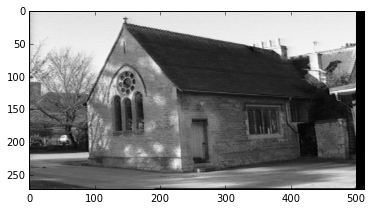

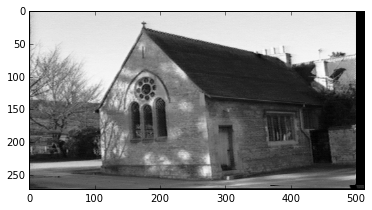

In [3]:
%matplotlib inline
pic1 = cv2.imread("Files/chapel1.png")
pic2 = cv2.imread("Files/chapel2.png")

pic1 = cv2.cvtColor( pic1, cv2.COLOR_BGR2GRAY)
pic2 = cv2.cvtColor( pic2, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(pic1, cmap="Greys_r")
plt.figure()
plt.imshow(pic2, cmap="Greys_r")

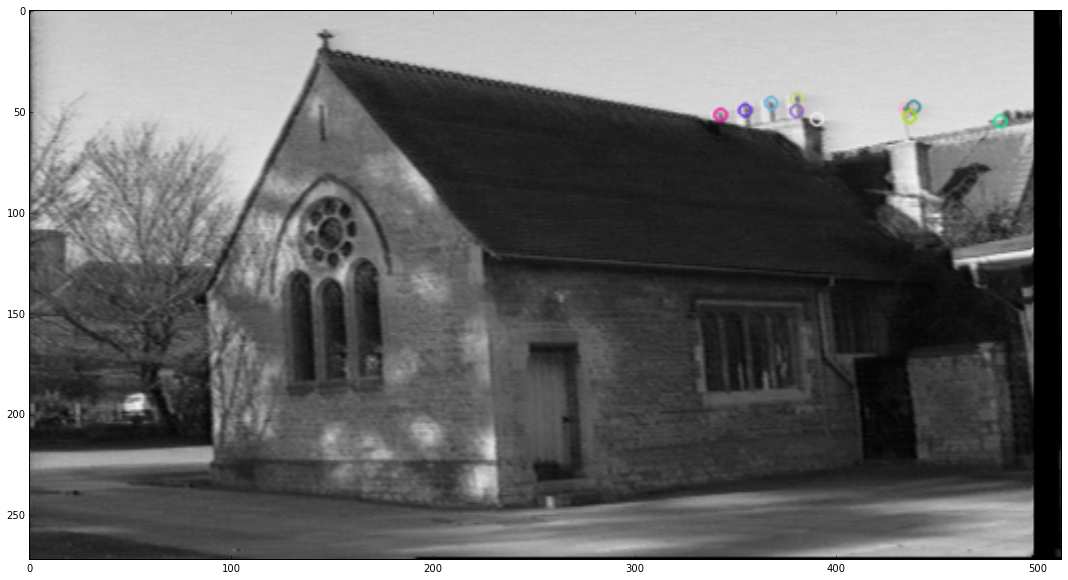

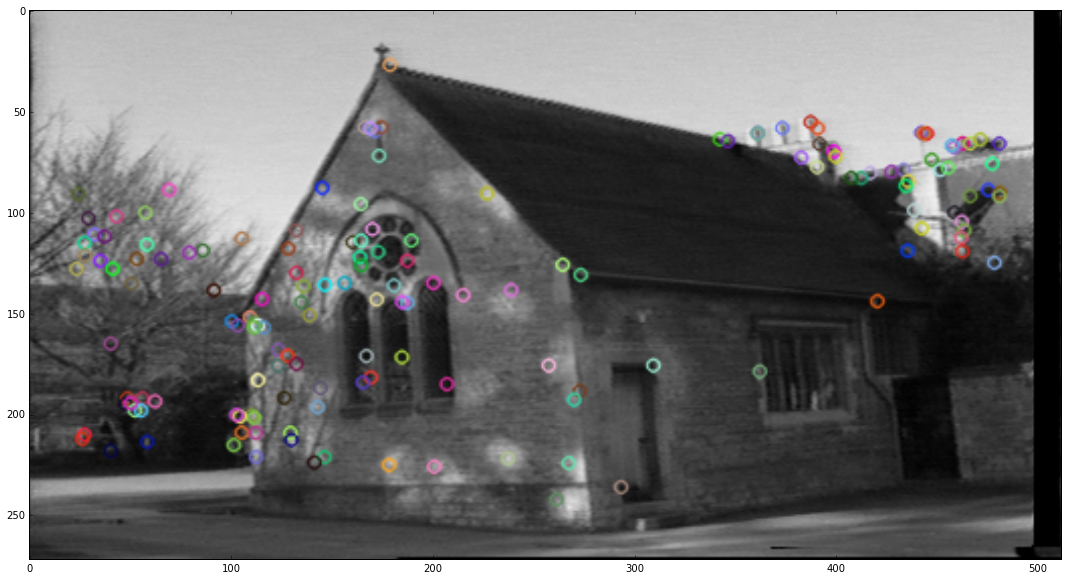

In [39]:
def extract_features(img):
    brisk=cv2.BRISK()
    kps,descs=brisk.detectAndCompute(img,None)
    return (kps,descs)

kp1, des1 = extract_features(pic1)
img1=cv2.drawKeypoints(pic1,kp1[:10])
f1=plt.figure()
f1.set_size_inches(18.5, 10.5)
plt.imshow(img1)

kp2, des2 = extract_features(pic2)
img2=cv2.drawKeypoints(pic2,kp2)
f2=plt.figure()
f2.set_size_inches(18.5, 10.5)
plt.imshow(img2)

In [5]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out

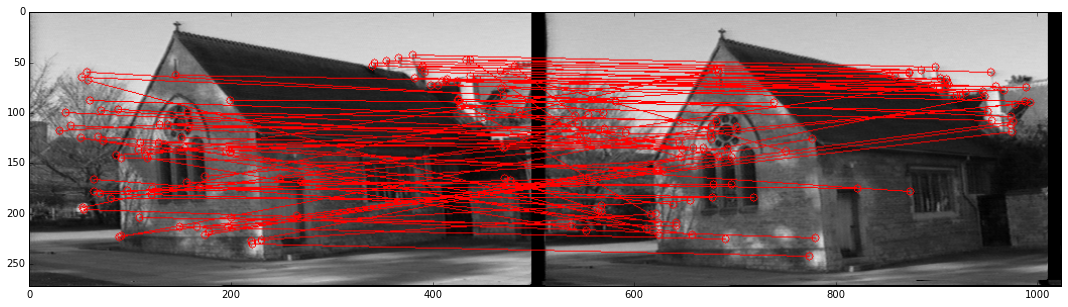

In [6]:
def match_kp(descs1,descs2):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(descs1, descs2, 2)
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * .75:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    return matches

def match_kp2(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Do matching
    matches = bf.match(des1,des2)
    # Sort the matches based on distance.  Least distance
    # is better
    matches = sorted(matches, key=lambda val: val.distance)
    return matches
    
matches = match_kp2(des1, des2)

img3 = drawMatches(pic1,kp1,pic2,kp2, matches)

f1=plt.figure()
f1.set_size_inches(18.5, 10.5)
plt.imshow(img3)


In [40]:
matched = match_kp(des1, des2)


# selectng only the best matches

pts1 = np.float32([kp1[i].pt for (_,i) in matched])
pts2 = np.float32([kp2[i].pt for (i,_) in matched])


F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
inlier1 = pts1[mask.ravel()==1]
inlier2 = pts2[mask.ravel()==1]

out1 = [pt for pt in pts1 if pt not in inlier1]
out2 = [pt for pt in pts2 if pt not in inlier2]

11


In [42]:
from sklearn.preprocessing import normalize

normed_F = normalize(F, axis=0, norm='l1')
# nom = sum(F)
# print sum(nom)
# print normed_F
# print F
print len(inlier1)
print len(inlier2)

print len(out1)
print len(out2)

7
7
4
3


In [ ]:
# outliers
kp_out1 = map(lambda x: cv2.KeyPoint(x[0], x[1],1),  out1 )
kp_out2 = map(lambda x: cv2.KeyPoint(x[0], x[1],1),  out2 )

kp_in1 = map(lambda x: cv2.KeyPoint(x[0], x[1],1),  inlier1 )
kp_in2 = map(lambda x: cv2.KeyPoint(x[0], x[1],1),  inlier2 )

# print kp_out1

img4 = cv2.drawKeypoints(pic1,kp_out1)
f4 = plt.figure()
f4.set_size_inches(18.5, 10.5)
plt.imshow(img4)

img5 = cv2.drawKeypoints(pic2,kp_out2)
f5 = plt.figure()
f5.set_size_inches(18.5, 10.5)
plt.imshow(img5)

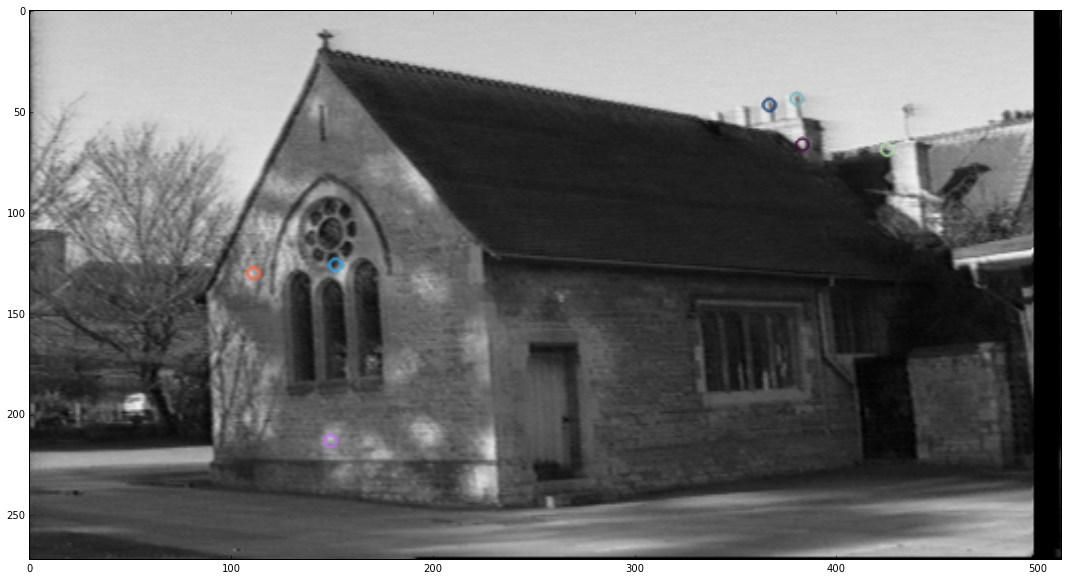

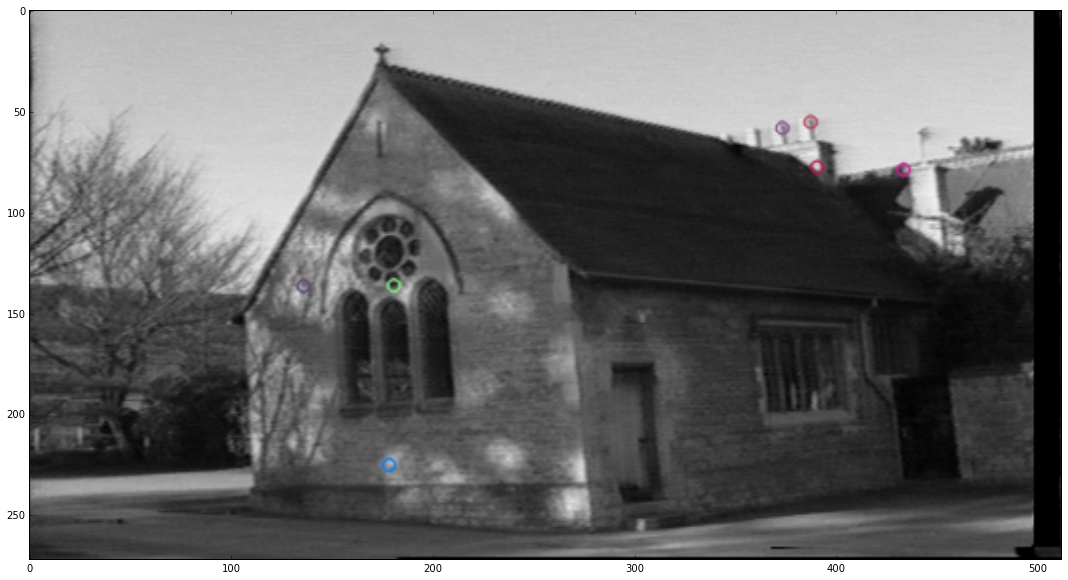

In [38]:
# inliers
img6 = cv2.drawKeypoints(pic1,kp_in1)
f6 = plt.figure()
f6.set_size_inches(18.5, 10.5)
plt.imshow(img6)

img7 = cv2.drawKeypoints(pic2,kp_in2)
f7 = plt.figure()
f7.set_size_inches(18.5, 10.5)
plt.imshow(img7)

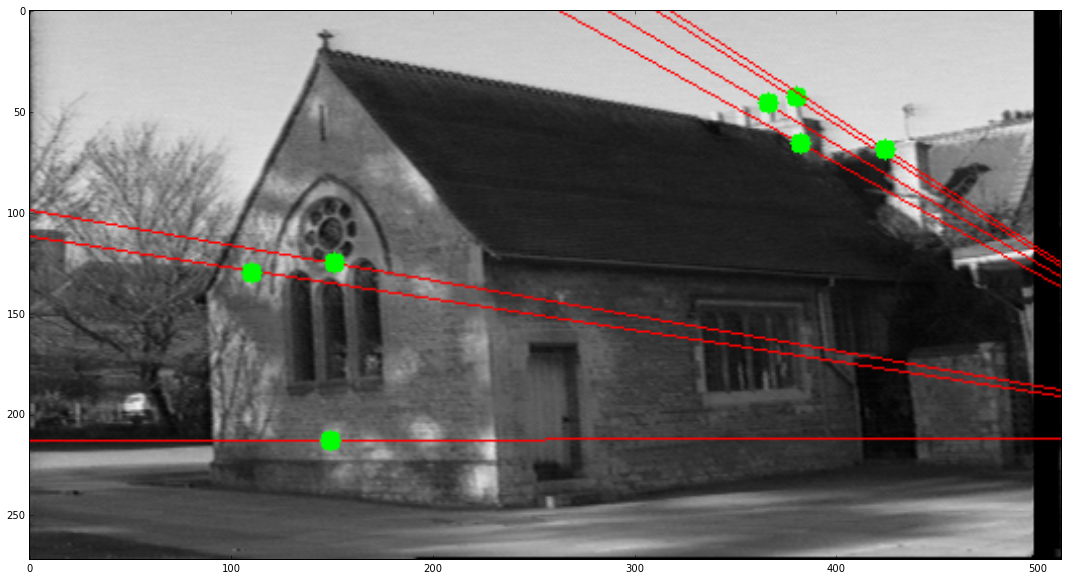

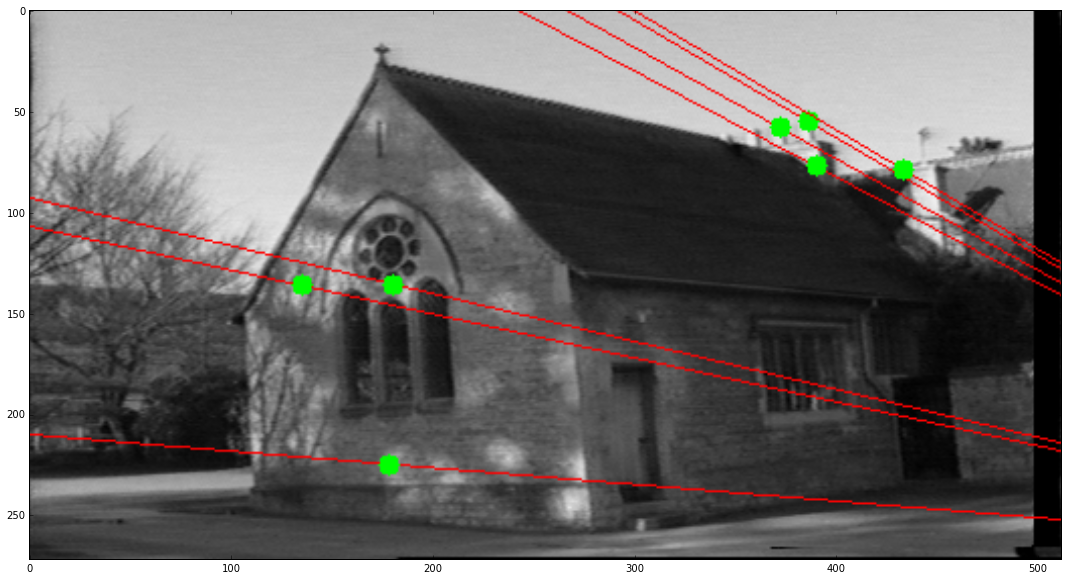

In [70]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
#         color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(img1, (x0,y0), (x1,y1), (255,0,0) ,1)
        cv2.circle(img1,tuple(pt1),5,(0,255,0),-1)
        cv2.circle(img2,tuple(pt2),5,(0,255,0),-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(inlier2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
res1,res2 = drawlines(pic1,pic2,lines1,inlier1,inlier2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(inlier1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
res3,res4 = drawlines(pic2,pic1,lines2,inlier2,inlier1)

# plt.figure(),plt.imshow(img5)
# plt.figure(),plt.imshow(img3)

f6 = plt.figure()
f6.set_size_inches(18.5, 10.5)
plt.imshow(res1)

f6 = plt.figure()
f6.set_size_inches(18.5, 10.5)
plt.imshow(res3)